In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from helpers import *

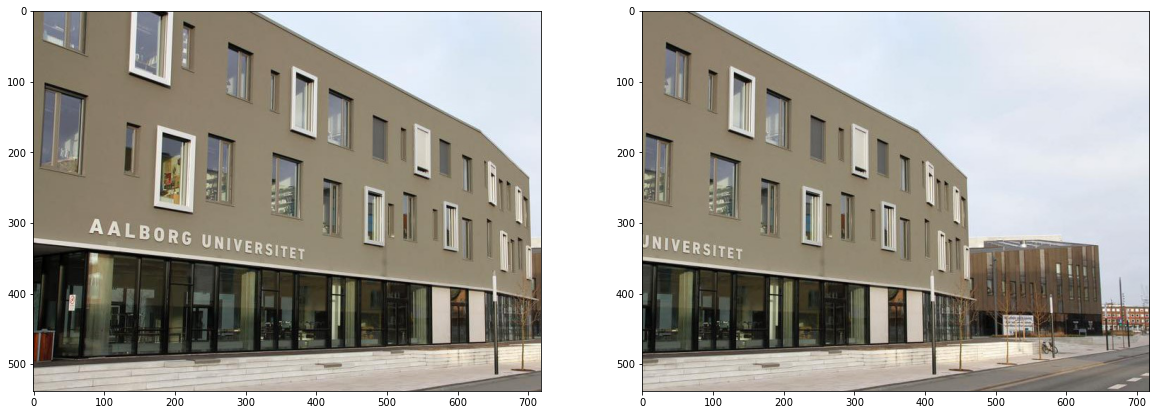

In [2]:
image1 = cv2.imread('../Images/aau-city-1.jpg')
image2 = cv2.imread('../Images/aau-city-2.jpg')

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(image1)
ax[1].imshow(image2)

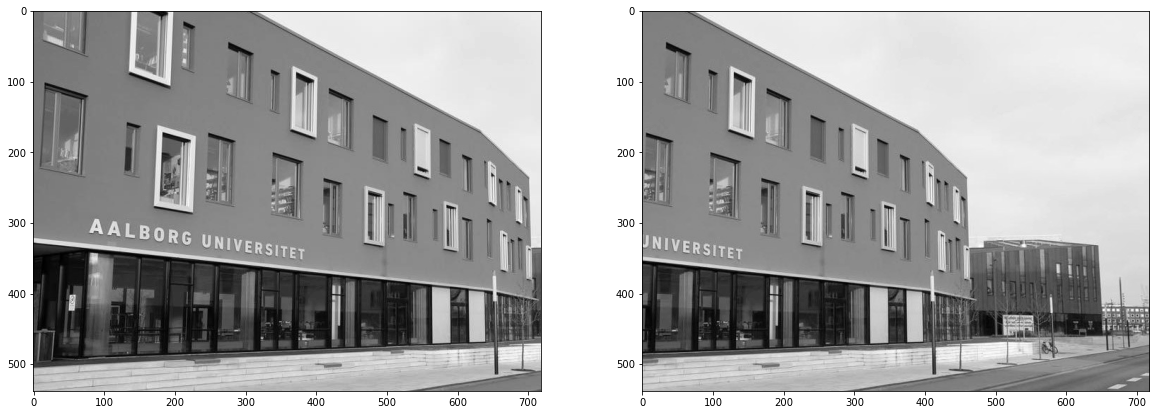

In [3]:
image1_gray = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_gray = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(image1_gray, cmap='gray')
ax[1].imshow(image2_gray, cmap='gray')

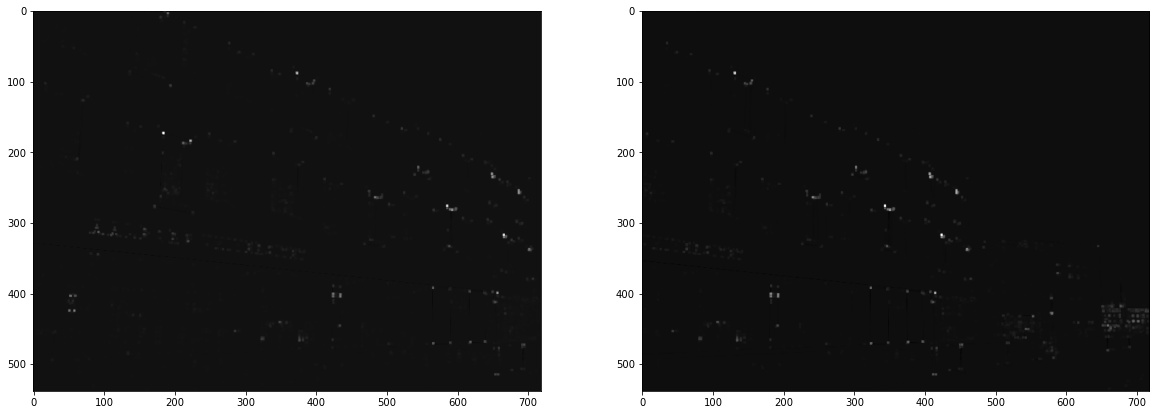

In [4]:
BLOCK_SIZE = 2
KERNEL_SIZE = 3
K = 0.04

harris1 = cv2.cornerHarris(image1_gray, BLOCK_SIZE, KERNEL_SIZE, K)
harris2 = cv2.cornerHarris(image2_gray, BLOCK_SIZE, KERNEL_SIZE, K)

harris1 = cv2.dilate(harris1, None)
harris2 = cv2.dilate(harris2, None)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(harris1, cmap='gray')
ax[1].imshow(harris2, cmap='gray')

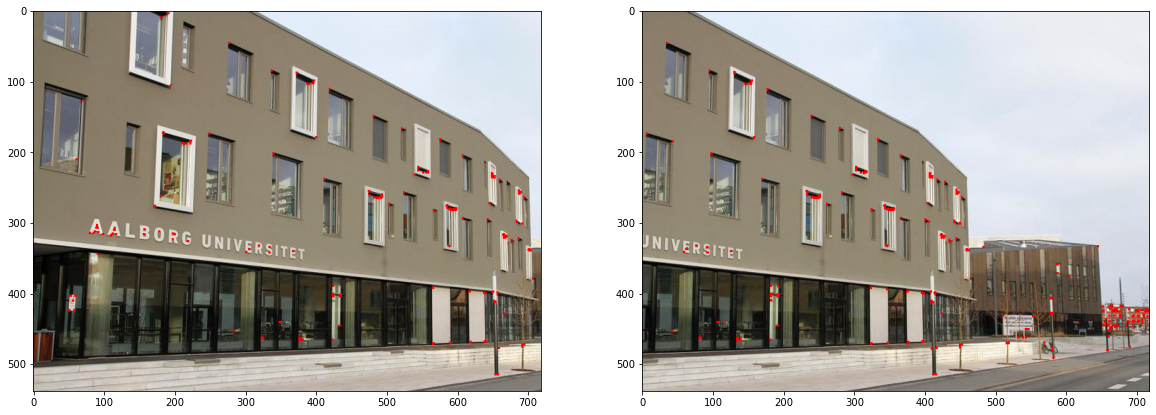

In [12]:
T = 0.08

image_harris1 = image1.copy()
image_harris2 = image2.copy()

image_harris1[harris1 > T * harris1.max()] = [255, 0, 0]
image_harris2[harris2 > T * harris2.max()] = [255, 0, 0]

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(image_harris1)
ax[1].imshow(image_harris2)

In [6]:
def get_coordinates(image, threshold=0.01):
    return np.argwhere(image > threshold * image.max())


def get_patches(image, coordinates, patch_size=9):
    patch_radius = patch_size // 2
    
    patches = list()
    
    for c in coordinates:
        if (c[0] < patch_radius or
            c[1] < patch_radius or
            c[0] > image.shape[0] - patch_radius - 1 or
            c[1] > image.shape[1] - patch_radius - 1):
            continue

        patch = image[c[0] - patch_radius:c[0] + patch_radius + 1,
                      c[1] - patch_radius:c[1] + patch_radius + 1]

        patches.append((c, patch))
    
    return patches


def get_correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    
    stds = patch1.std() * patch2.std()
    
    if stds == 0:
        return 0
    else:
        return product / stds
  
    
def match_patches(patches1, patches2, min_correlation=0.9):
    matches = list()
    
    for c1, p1 in tqdm(patches1):
        best_correlation = 0
        best_match = None
        
        for c2, p2 in patches2:
            correlation = get_correlation_coefficient(p1, p2)
            
            if correlation > best_correlation:
                best_correlation = correlation
                best_match = c2
        
        if best_correlation > min_correlation:
            matches.append((c1, best_match))
    
    return matches

In [20]:
T = 0.05
PATCH_SIZE = 15
MIN_CORRELATION = 0.95

coordinates1 = get_coordinates(harris1, T)
coordinates2 = get_coordinates(harris2, T)

patches1 = get_patches(image1_gray, coordinates1, PATCH_SIZE)
patches2 = get_patches(image2_gray, coordinates2, PATCH_SIZE)

matches = match_patches(patches1, patches2, MIN_CORRELATION)

len(matches)

  0%|          | 0/2483 [00:00<?, ?it/s]

1836

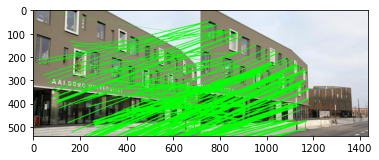

In [21]:
matched_image = np.concatenate((image1, image2), axis=1)

offset = image1.shape[1]

for m in matches:
    cv2.line(matched_image, m[0], (m[1][1] + offset, m[1][0]), (0, 255, 0), 1)

plt.imshow(matched_image)